In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
pd.options.display.max_columns = 50
from collections import defaultdict

Task 2:

Look over all of the historical positive test count, positive test percentage, death and hospitalization data for the United States and its regions, from the start of the pandemic, and find your best estimate of the amount of lag time between:

D) Cases and hospitalizations

E) Cases and deaths

F) Hospitalizations and deaths

Do this with as many different states/regions as seems to make sense to you.

In [2]:
us_hos_df = pd.read_csv('./data/us/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries.csv')

In [3]:
desired_columns = ['state', 'date', 'previous_day_admission_adult_covid_confirmed', 'previous_day_admission_adult_covid_suspected']
col_rename = {'previous_day_admission_adult_covid_confirmed': 'hospital_covid_confirmed', 'previous_day_admission_adult_covid_suspected': 'hospital_covid_suspected'}
us_hos_df = us_hos_df[desired_columns]
us_hos_df = us_hos_df.rename(mapper=col_rename, axis=1)
us_hos_df['hospital_both'] = us_hos_df['hospital_covid_confirmed'] + us_hos_df['hospital_covid_suspected']
us_hos_df['date'] = pd.to_datetime(us_hos_df['date'])
us_hos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35219 entries, 0 to 35218
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   state                     35219 non-null  object        
 1   date                      35219 non-null  datetime64[ns]
 2   hospital_covid_confirmed  28438 non-null  float64       
 3   hospital_covid_suspected  28287 non-null  float64       
 4   hospital_both             28284 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.3+ MB


In [4]:
us_death_case_df = pd.read_csv('./data/us/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

In [5]:
us_death_case_df['date'] = pd.to_datetime(us_death_case_df['submission_date'])
desired_columns = ['state', 'date', 'new_case', 'pnew_case', 'new_death', 'pnew_death']
us_death_case_df = us_death_case_df[desired_columns]
us_death_case_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41760 entries, 0 to 41759
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   state       41760 non-null  object        
 1   date        41760 non-null  datetime64[ns]
 2   new_case    41746 non-null  float64       
 3   pnew_case   37801 non-null  float64       
 4   new_death   41746 non-null  float64       
 5   pnew_death  37740 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
us_df = pd.merge(us_death_case_df, us_hos_df).sort_values('date')

## Method

We will test lag times between 0 and 60 days, between cases and hosipitalization, and cases and death.

For each proposed lag time, we assume there will be a constant ratio between cases and hospitalization, and cases and death.

The days of lag that would result in the least deviation from the above assumption would be determined as the correct days of lag.

Some normalization to population would be done, with state populationd data from the [US Census Bureau](https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/)

In [7]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [8]:
us_pop = pd.read_csv('./data/us/nst-est2020.csv')


us_pop['state'] = us_pop.apply(lambda x: us_state_to_abbrev[x['NAME']] if x['NAME'] in us_state_to_abbrev else None, axis=1)
us_pop.dropna(inplace=True)

us_pop['population'] = us_pop['POPESTIMATE2020']
us_pop_dict = {}
for i, row in us_pop.iterrows():
    us_pop_dict[row['state']] = row['population']
print(us_pop_dict)
us_pop_dict['VI'] = 106290
us_pop_dict['AS'] = 55197

{'AL': 4921532, 'AK': 731158, 'AZ': 7421401, 'AR': 3030522, 'CA': 39368078, 'CO': 5807719, 'CT': 3557006, 'DE': 986809, 'DC': 712816, 'FL': 21733312, 'GA': 10710017, 'HI': 1407006, 'ID': 1826913, 'IL': 12587530, 'IN': 6754953, 'IA': 3163561, 'KS': 2913805, 'KY': 4477251, 'LA': 4645318, 'ME': 1350141, 'MD': 6055802, 'MA': 6893574, 'MI': 9966555, 'MN': 5657342, 'MS': 2966786, 'MO': 6151548, 'MT': 1080577, 'NE': 1937552, 'NV': 3138259, 'NH': 1366275, 'NJ': 8882371, 'NM': 2106319, 'NY': 19336776, 'NC': 10600823, 'ND': 765309, 'OH': 11693217, 'OK': 3980783, 'OR': 4241507, 'PA': 12783254, 'RI': 1057125, 'SC': 5218040, 'SD': 892717, 'TN': 6886834, 'TX': 29360759, 'UT': 3249879, 'VT': 623347, 'VA': 8590563, 'WA': 7693612, 'WV': 1784787, 'WI': 5832655, 'WY': 582328, 'PR': 3159343}


In [9]:
def loss(input_df, lag, col0, col1):
    df = input_df.copy()
    df['lagged'] = df.shift(-lag)[col1]
    show_cols = [col0, 'lagged', 'implied', 'date', col1]
    df['implied'] =  df[col0] / df['lagged']
    df['implied'].replace([0, np.inf], np.nan, inplace=True)
    implied = df['implied'].dropna()
    implied = implied[implied > 1]
    return implied.std(), scipy.stats.hmean(implied)
    

In [10]:
def find_lag(input_df, col0, col1, max_lag=60):
    to_check = range(0, max_lag)
    scores = np.zeros((len(to_check),2))
    for i in to_check:
        scores[i,0], scores[i,1] = loss(input_df, i, col0, col1)
    roll_window = 7
    rolls = pd.Series(scores[:,0]).rolling(window=5).mean()
    roll_cutoff = roll_window-1
    rolls[:roll_cutoff] = scores[:roll_cutoff,0]
    min_ind = rolls.argmin()
    return min_ind, scores[min_ind, 1], scores[min_ind, 0]

In [11]:
states = us_df['state'].unique()

In [12]:
import warnings
state_data = defaultdict(dict)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for state in states:
        cases = us_df[us_df['state'] == state].rolling(window=7, on="date").mean()
        death_lag, death_ratio, death_std = find_lag(cases, 'new_case', 'new_death')
        hospital_lag, hospital_ratio, hospital_std = find_lag(cases, 'new_case', 'hospital_covid_confirmed')
        state_data[state] = {
            'hospital_lag': hospital_lag,
            'hospital_ratio': hospital_ratio,
            'hospital_std': hospital_std,
            'death_lag': death_lag,
            'death_ratio': death_ratio,
            'death_std': death_std,
            'population': us_pop_dict[state]
        }
    

## Sanity Check

If the obtained lag time values are correct, then graphing death and hospitalization counts with their respective calculated lag times, alongside the case counts, should yield very similar shapes

The peaks and troughs should match for the vast majority of cases, and that is indeed what we observe.

Due to there being 54 states and limited space, the legend may be difficult to see.
* Blue line: Case count
* Orange line: Death count
* Green line: Hospitalization count

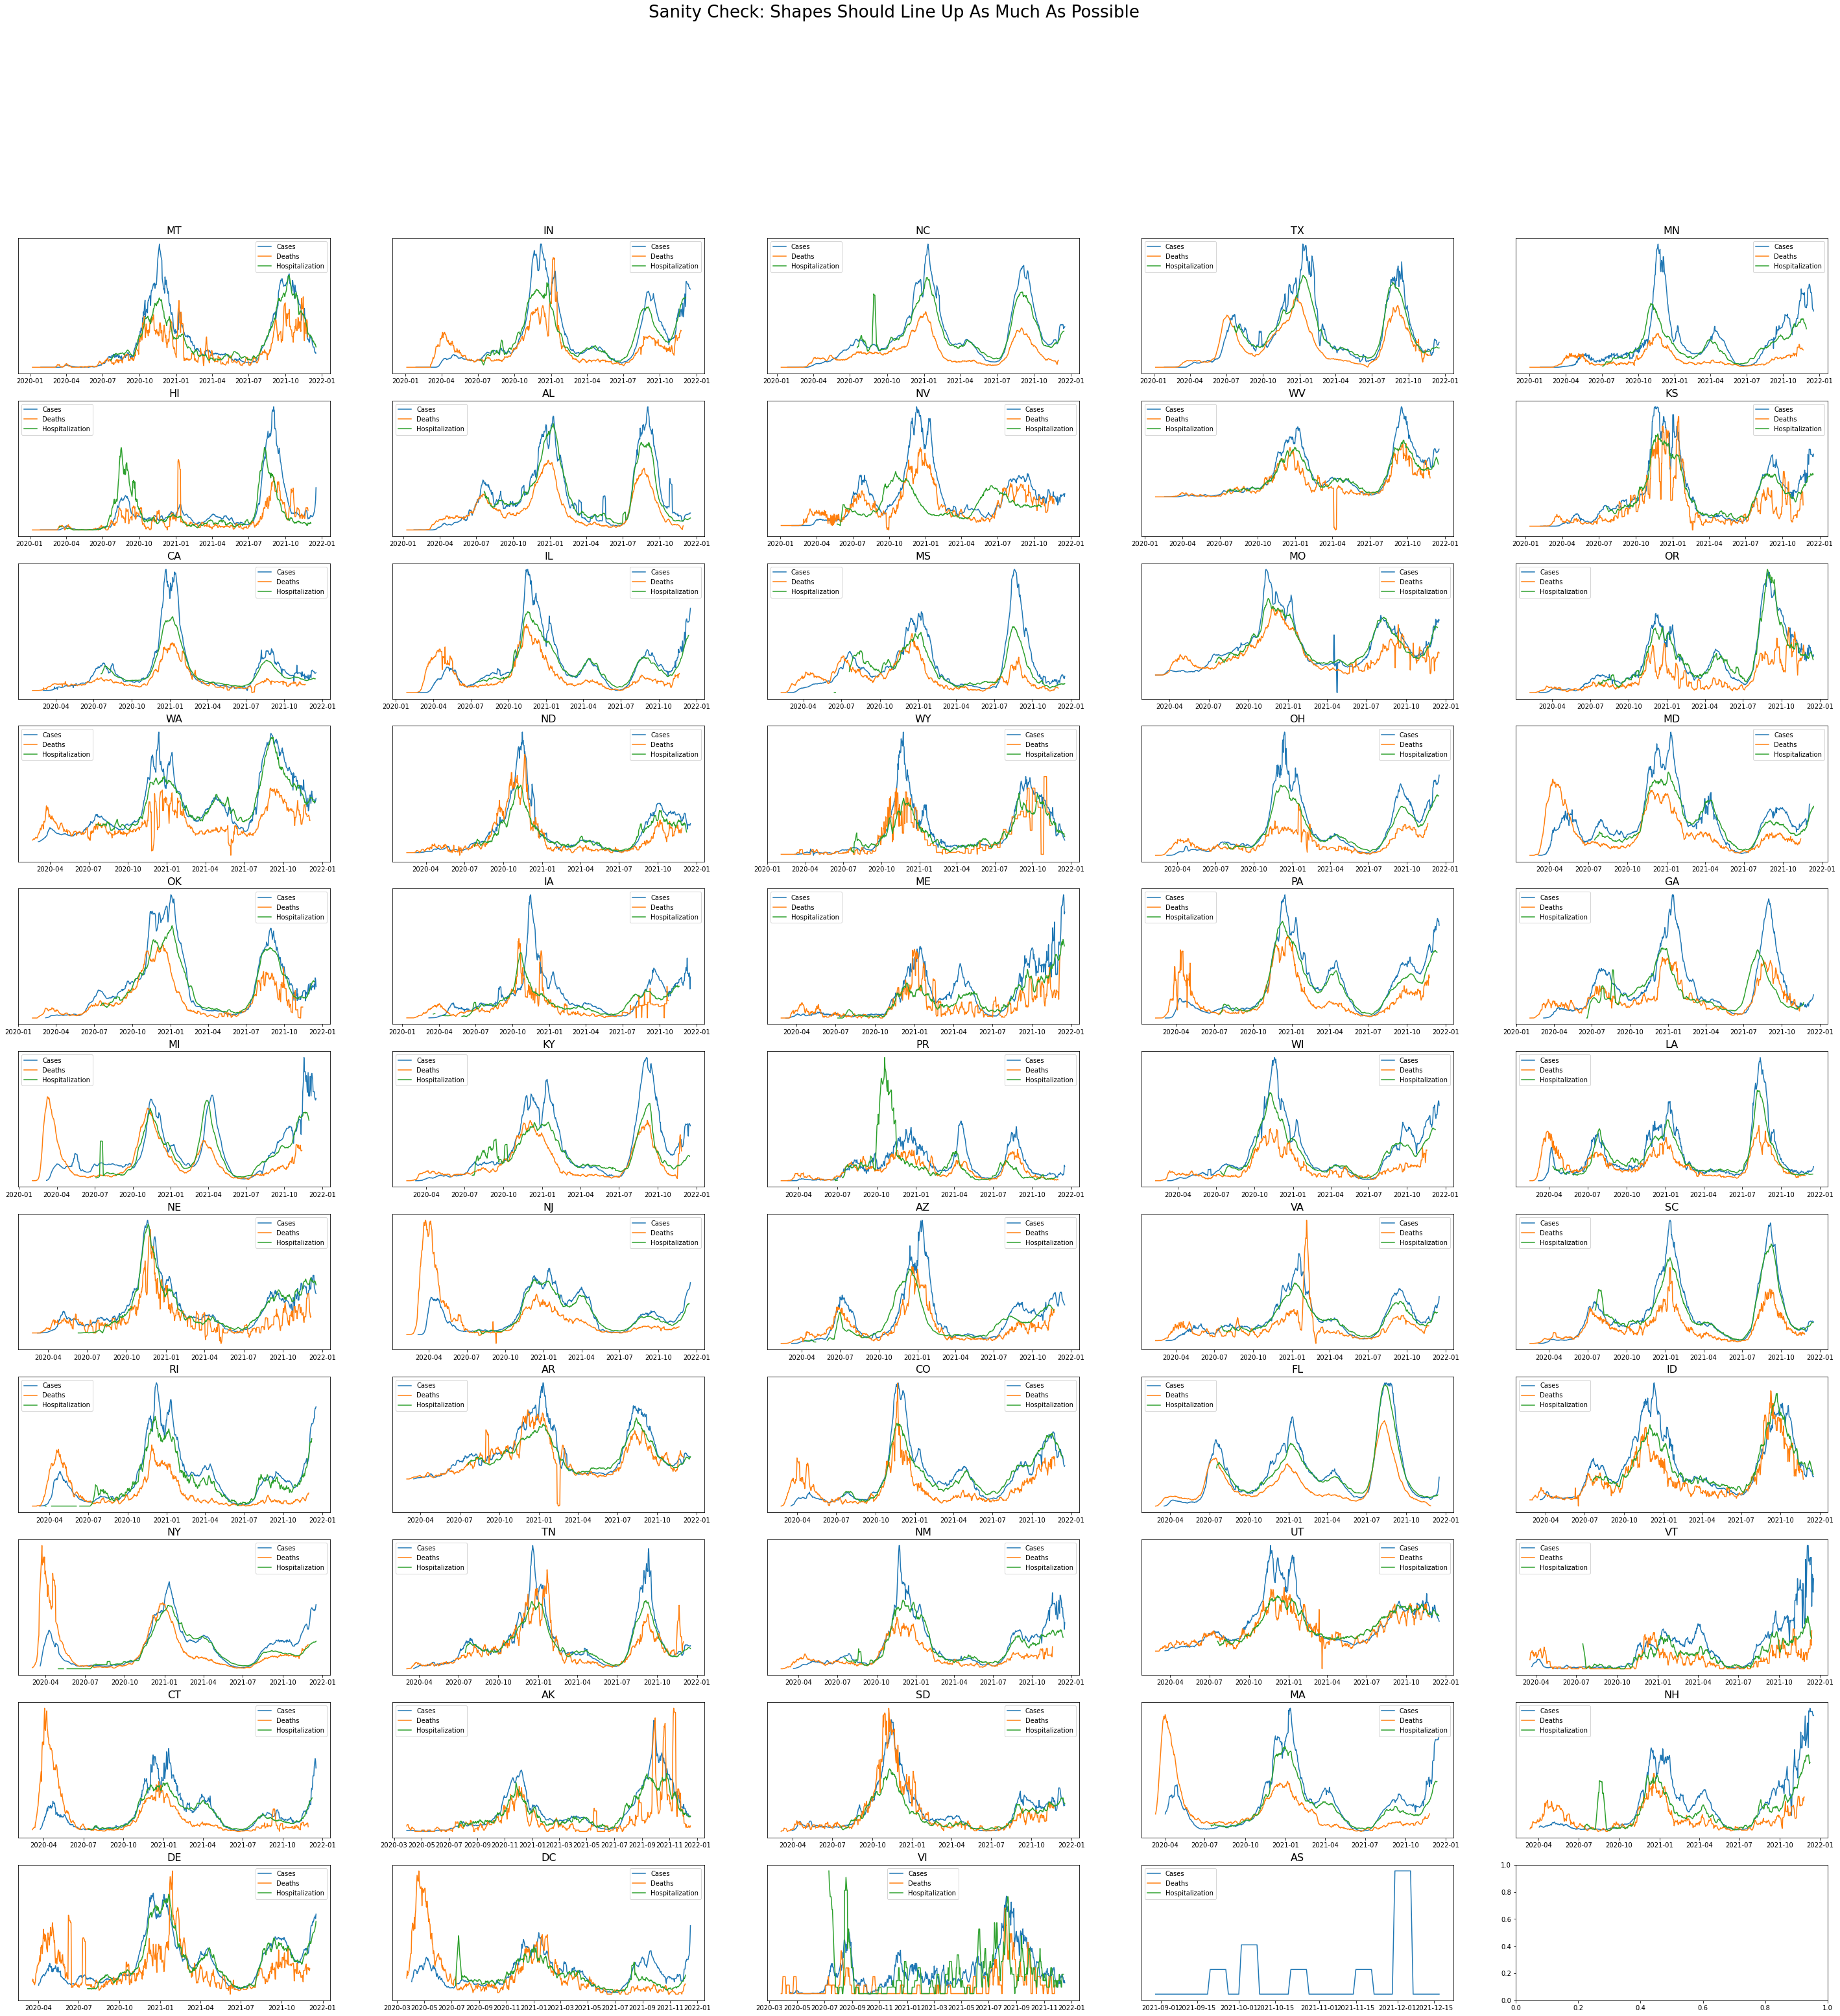

In [13]:
grid = (11,5)
fig, axes = plt.subplots(grid[0], grid[1], figsize=(50, 50))
i = 0
for state, data in state_data.items():
    ind = i//grid[1], i%grid[1]
    ax = axes[i//grid[1], i%grid[1]]
    i += 1
    cases = us_df[us_df['state'] == state].rolling(window=7, on="date").mean()
    ax.plot(cases['date'], cases['new_case'], label="Cases")
    ax.plot(cases['date']-pd.tseries.offsets.Day(data['death_lag']), data['death_ratio']*cases['new_death'], label="Deaths")
    ax.plot(cases['date']-pd.tseries.offsets.Day(data['hospital_lag']), data['hospital_ratio']*cases['hospital_covid_confirmed'], label="Hospitalization")
    ax.set_title(state, fontsize=16)
    ax.get_yaxis().set_visible(False)
    ax.legend()
fig.suptitle("Sanity Check: Shapes Should Line Up As Much As Possible", fontsize=26)
plt.show()

## Hospitalization Lag Time

We graph case count to hospitalization count lag time on the y axis, with deviation from constant ratio between case counts and hospitalization counts on the x axis.

The further on the right a datapoint is, the less confidence we can be that it its lag time value is accurate, or can be inferred at all from the data.



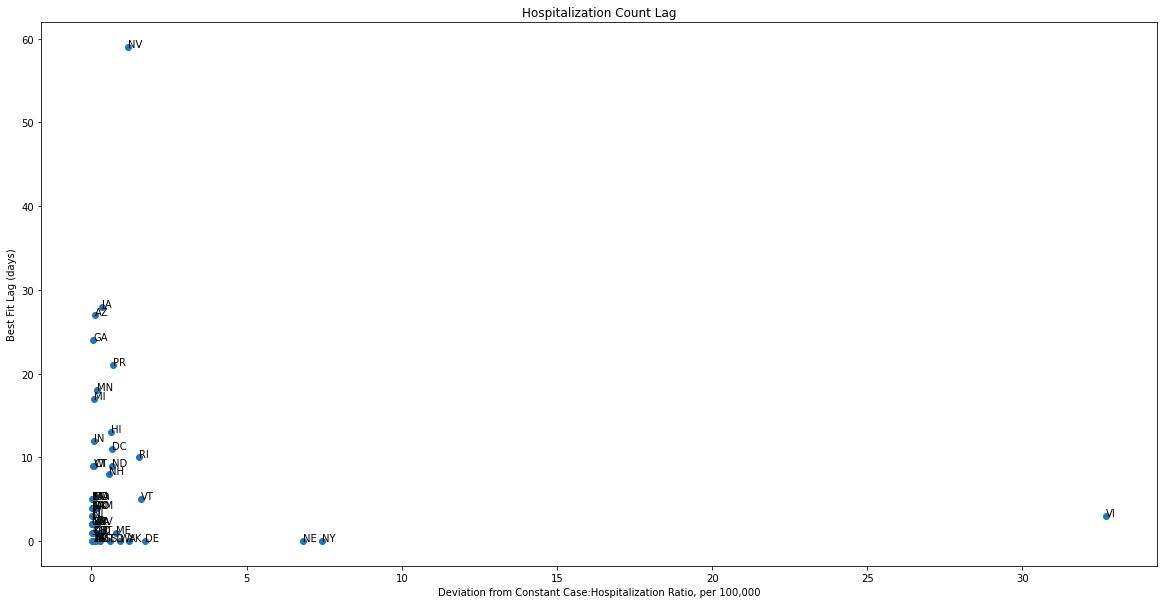

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
state_items = list(state_data.items())
state_items = [(k,v) for k,v in state_items if k != 'AS']
pops = [v['population'] for k,v in state_items]
hospital_stds = [v['hospital_std']/v['population']*100000 for k,v in state_items]
hospital_lags = [v['hospital_lag'] for k,v in state_items]
state_labels = [k for k,v in state_items]

for i, label in enumerate(state_labels):
    ax.annotate(label, (hospital_stds[i], hospital_lags[i]))

ax.set_ylabel("Best Fit Lag (days)")
ax.set_xlabel("Deviation from Constant Case:Hospitalization Ratio, per 100,000")
ax.set_title("Hospitalization Count Lag")
ax.scatter(hospital_stds, hospital_lags)
plt.show()

## Death Lag Time

We graph case count to death count lag time on the y axis, with deviation from constant ratio between case counts and death counts on the x axis.

The further on the right a datapoint is, the less confidence we can be that it its lag time value is accurate, or can be inferred at all from the data.




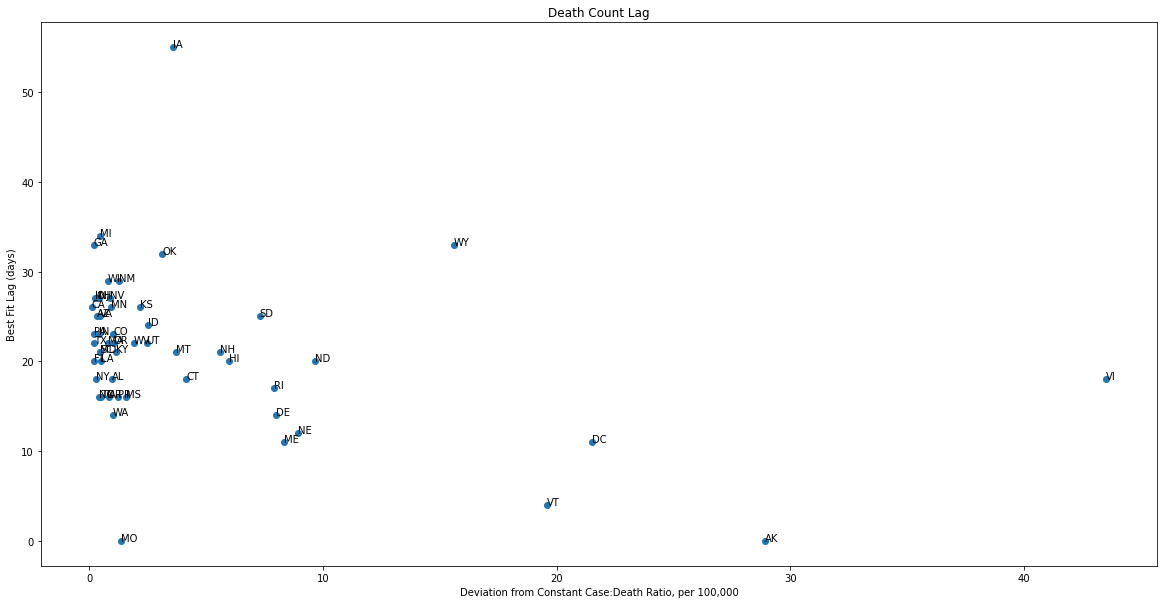

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
death_stds = [v['death_std']/v['population']*100000 for k,v in state_items]
death_lags = [v['death_lag'] for k,v in state_items]
state_labels = [k for k,v in state_items]

for i, label in enumerate(state_labels):
    ax.annotate(label, (death_stds[i], death_lags[i]))

ax.set_ylabel("Best Fit Lag (days)")
ax.set_xlabel("Deviation from Constant Case:Death Ratio, per 100,000")
ax.set_title("Death Count Lag")
ax.scatter(death_stds, death_lags)
plt.show()

In [16]:
hospital_lag_mean_weighted = np.average(hospital_lags, weights=pops)
hospital_lag_mean = np.average(hospital_lags)
print(hospital_lag_mean_weighted, hospital_lag_mean)

5.554790967299763 6.584905660377358


In [17]:
death_lag_mean_weighted = np.average(death_lags,  weights=pops)
death_lag_mean = np.average(death_lags)
print(death_lag_mean_weighted, death_lag_mean)

22.812265896898207 21.30188679245283


## Weights and Means

The mean hospitalization lag behind cases is 6.58 days.

The mean death lag behind cases is 21.30 days.

### Unprincipled Weighting

If we were to weight the means by each states' population, we obtain:
* Mean weighted hospitalization lag behind cases of 5.55 days
* Mean weighted death lag behind cases of 22.81 days


## Against Priors: 0 Hospitalization Lag Time

Here we chart every state with a 0 calculated lag time between case count and hospitalization count

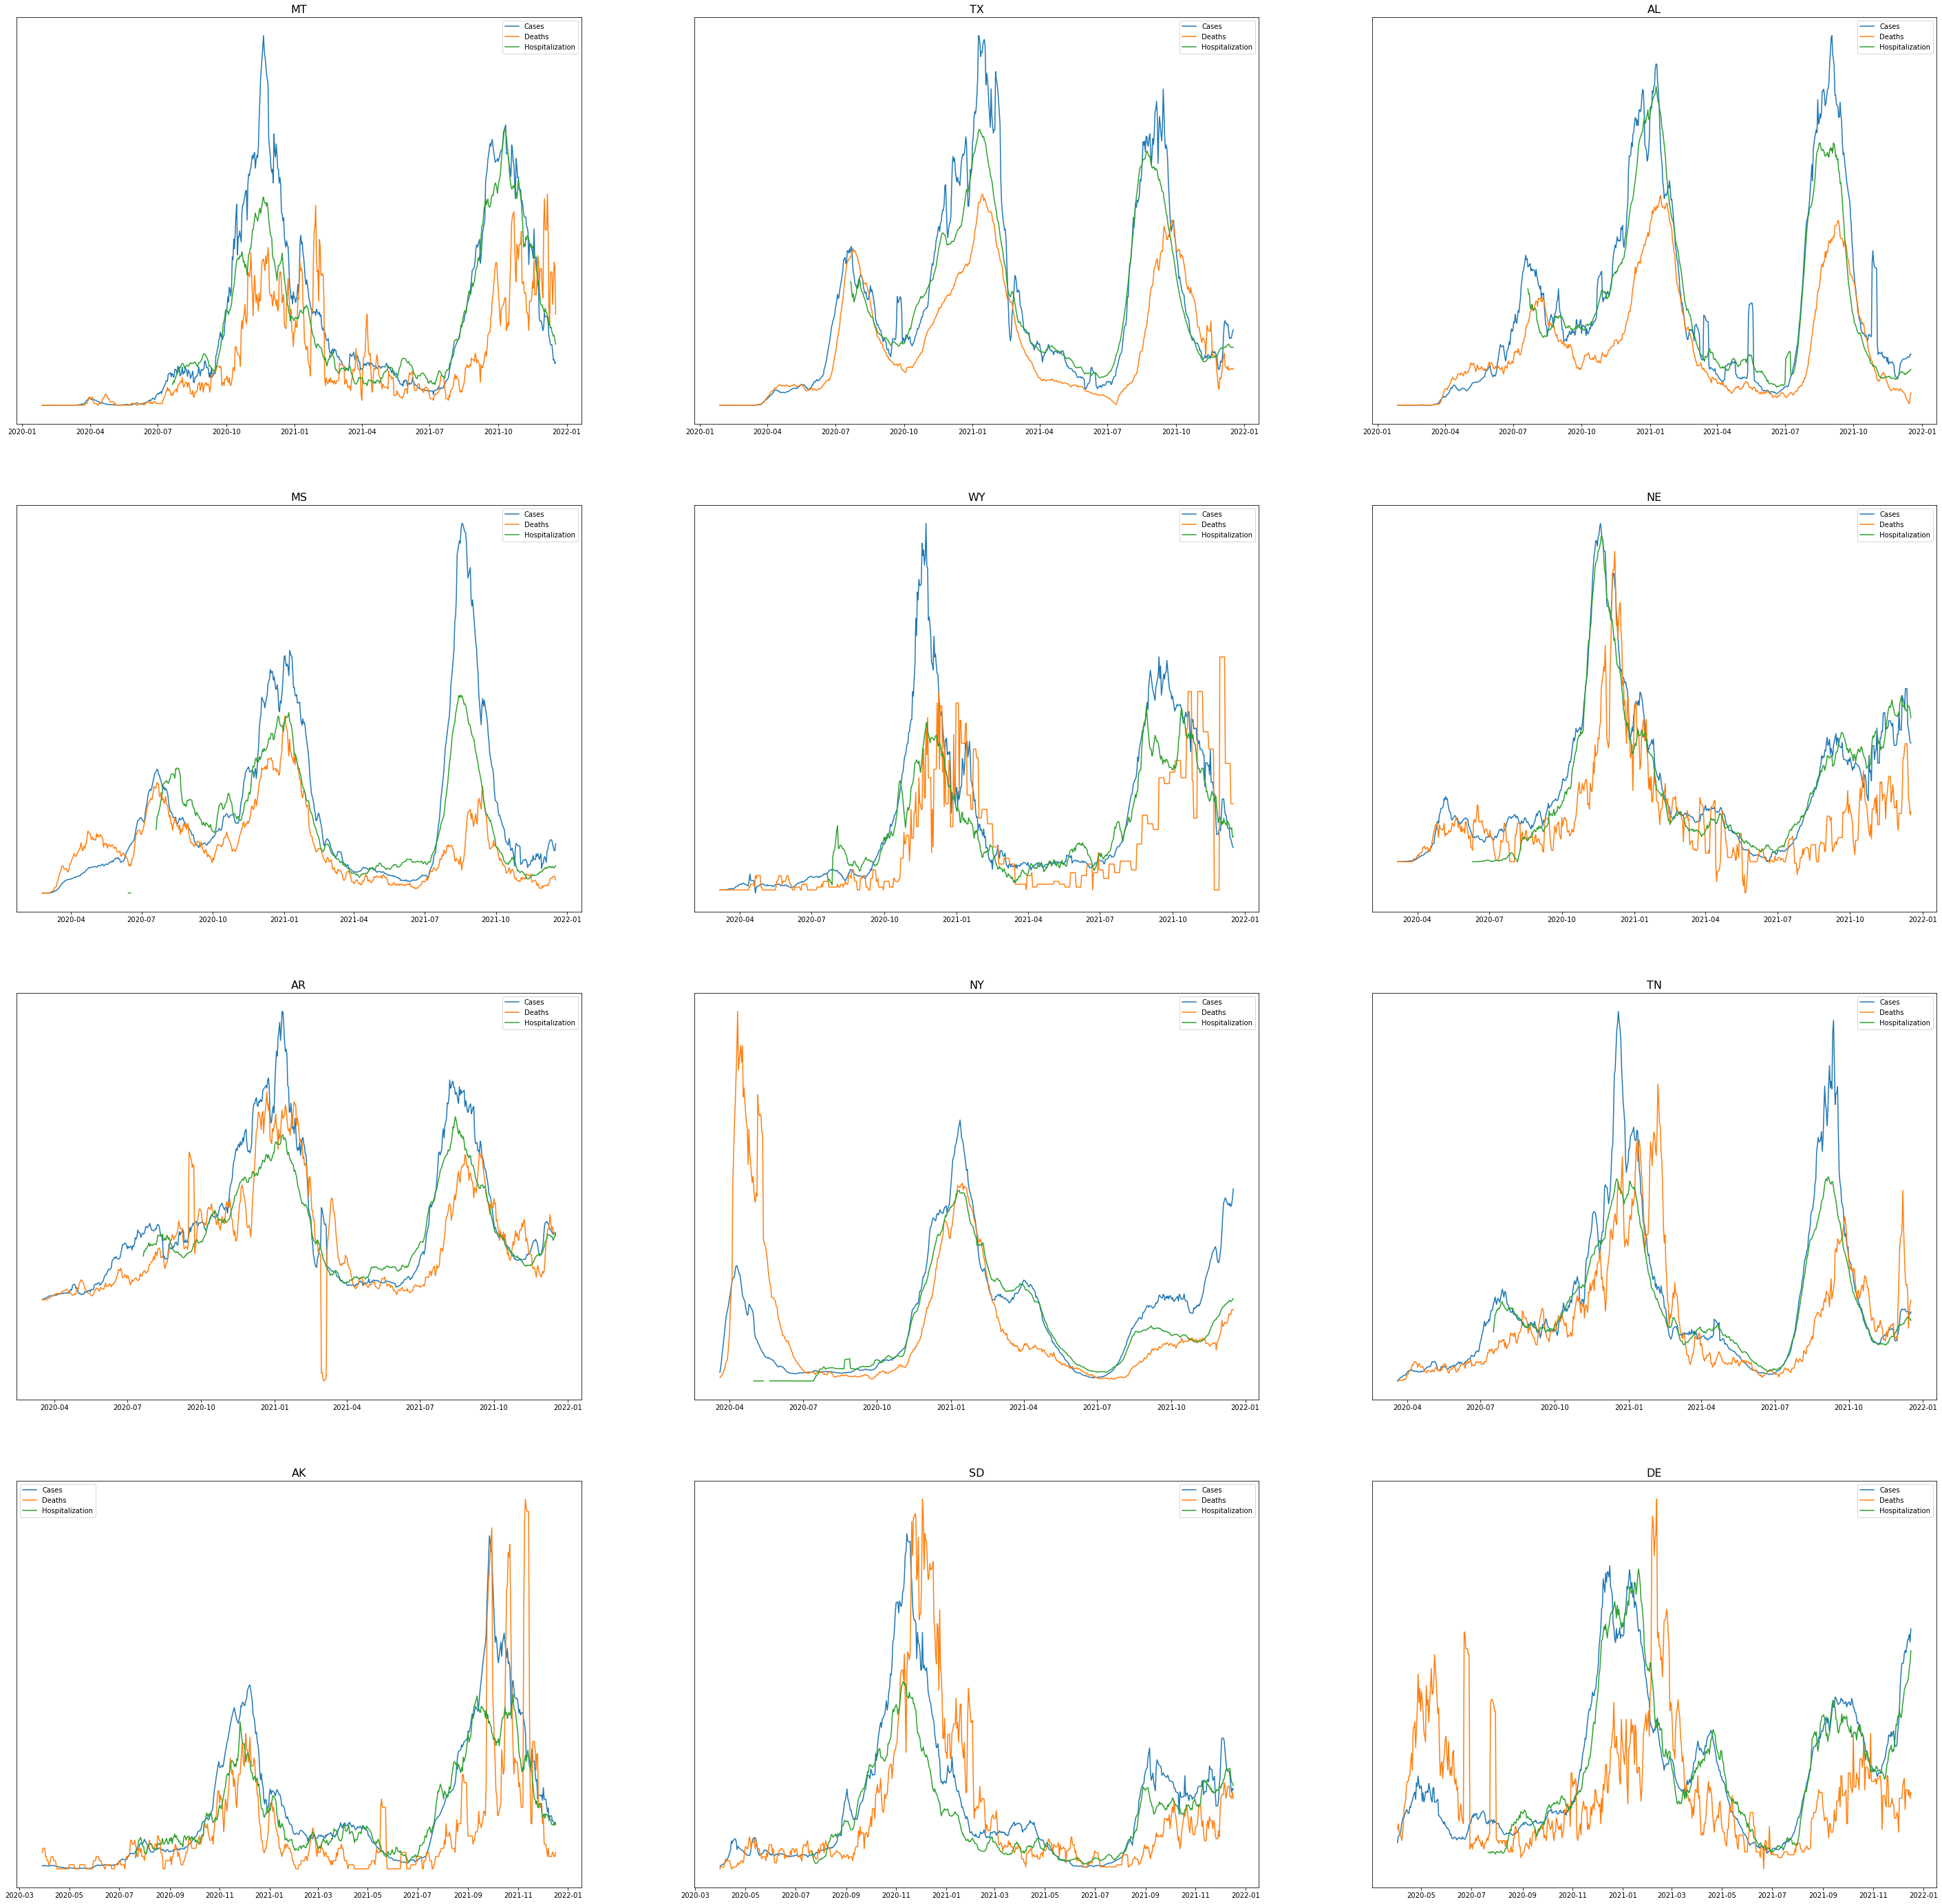

In [24]:
grid = (4,3)
fig, axes = plt.subplots(grid[0], grid[1], figsize=(50, 50))
i = 0
for state, data in state_data.items():
    if data['hospital_lag'] != 0:
        continue
    ind = i//grid[1], i%grid[1]
    ax = axes[i//grid[1], i%grid[1]]
    i += 1
    cases = us_df[us_df['state'] == state].rolling(window=7, on="date").mean()
    ax.plot(cases['date'], cases['new_case'], label="Cases")
    ax.plot(cases['date'], data['death_ratio']*cases['new_death'], label="Deaths")
    ax.plot(cases['date'], data['hospital_ratio']*cases['hospital_covid_confirmed'], label="Hospitalization", c='C2')
    ax.set_title(state, fontsize=16)
    ax.get_yaxis().set_visible(False)
    ax.legend()

We observe that in each case where the best fit case count to hospitalization count lag was 0 days, it matches the data:
* The peaks of the hospitalization line up with the peaks of the case counts
* The peaks of death counts, as expected, lag behind both case counts and hospitalization counts